## Predict scRNA-seq through MERFISH

uniPort trained an encoder network to project cells with common genes across datasets into a
common cell-embedding latent space and a decoder network to reconstruct cells with common and
specific genes. Therefore, once the coupled-VAE is trained well, it can be regarded as a reference atlas, in turn allowing uniPort to integrate new single-cell data in an online manner without modal retraining. Most importantly, uniPort can generate both common and specific genes in one dataset through common genes in another dataset by the atlas.

In [1]:
import uniport as up
import scanpy as sc
import pandas as pd

Read MERFISH and scRNA-seq with common genes. 

In [2]:
adata_cm = sc.read_h5ad('MERFISH/MERFISH_and_RNA.h5ad')
adata_merfish1 = adata_cm[adata_cm.obs['source']=='MERFISH'].copy()

Read cell type annotations of MERFISH profiled from a new mouse.

In [3]:
labels_mouse2 = pd.read_csv('MERFISH/MERFISH_mouse2_cluster.txt', sep='\t')
celltype_mouse2 = labels_mouse2['cluster_main'].values

In [4]:
adata_merfish2 = up.load_file('MERFISH/MERFISH_mouse2.txt')

Add information to `AnnData`. Identify the new MERFISH as domain '-1'.  

In [5]:
adata_merfish2.obs['cell_type'] = celltype_mouse2
adata_merfish2.obs['domain_id'] = -1
adata_merfish2.obs['domain_id'].astype('category')
adata_merfish2.obs['domain_id'] = adata_merfish2.obs['domain_id'].astype('category')
adata_merfish2.obs['source'] = 'MERFISH2'

Select common genes in new MERFISH data to make it consistent with training data. 

In [6]:
adata_cm = adata_merfish2.concatenate(adata_merfish1, join='inner', batch_key='domain_id')
adata_merfish2 = adata_cm[adata_cm.obs['source']=='MERFISH2'].copy()

Data normalization.

In [7]:
sc.pp.normalize_total(adata_merfish2)
sc.pp.log1p(adata_merfish2)
up.batch_scale(adata_merfish2)

Predict corresponding RNA gene expression through the new MERFISH data. Here pred_id is the doamin_id of the modality we want to predict.

In [8]:
adata = up.Run(adata_cm=adata_merfish2, out='predict', pred_id=1)

Perform UMAP visualization of predict scRNA-seq data.

... storing 'cell_type' as categorical
... storing 'source' as categorical


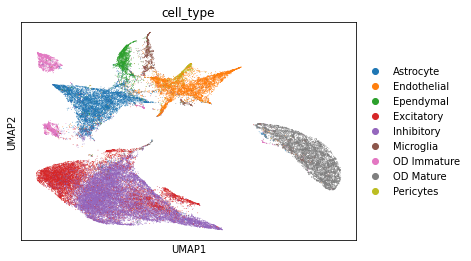

In [9]:
sc.pp.neighbors(adata, use_rep='predict')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['cell_type'])

In [10]:
print(adata.obsm['predict'].shape)

(59651, 2000)


Save the predicted data.

In [11]:
latent = adata.obsm['predict']
adata_rna = sc.read_h5ad('MERFISH/RNA.h5ad')
predict = pd.DataFrame(latent.T, index=adata_rna.var_names, columns=adata.obs_names)
predict.to_csv('MERFISH/Predict_mouse2_RNA.txt', sep='\t')